In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

house_df_org = pd.read_csv('house_price.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [4]:
print('데이터 세트의 Shape:', house_df.shape)

print('\n전체 피처의 type\n', house_df.dtypes.value_counts())

isnull_series = house_df.isnull().sum()
print('\nNull 칼럼과 그 건수:\n', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

전체 피처의 type
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 칼럼과 그 건수:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


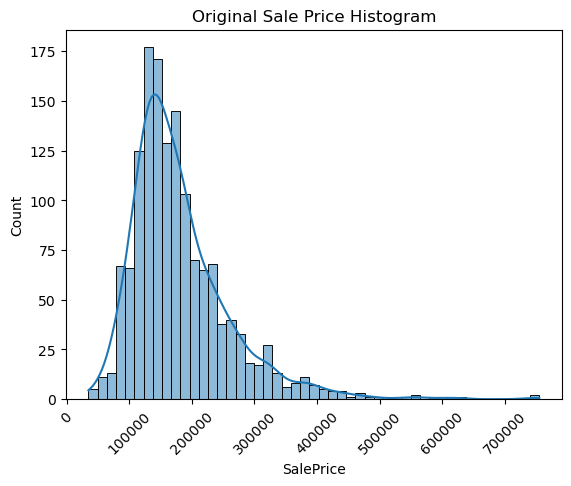

In [6]:
plt.title('Original Sale Price Histogram') 
plt.xticks(rotation=45)
sns.histplot(house_df['SalePrice'], kde=True)
plt.show()

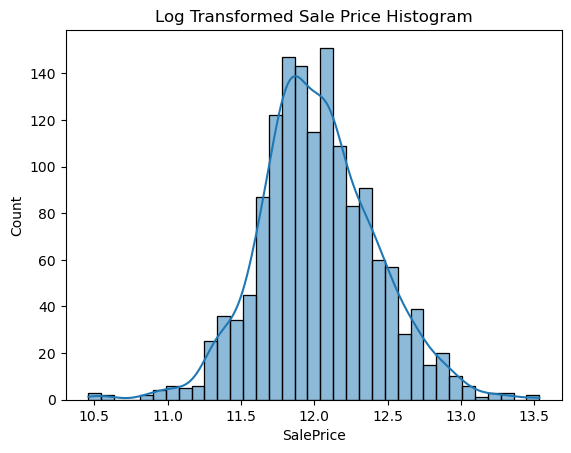

In [7]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

In [10]:
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

drop_cols = ['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
house_df.drop(columns=[c for c in drop_cols if c in house_df.columns], inplace=True)

house_df.fillna(house_df.mean(numeric_only=True), inplace=True)

null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type:\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type:
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [11]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type:\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 270)
## Null 피처의 Type:
 Series([], dtype: object)


In [12]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse, 3))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [13]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.003
Ridge 로그 변환된 RMSE: 0.003
Lasso 로그 변환된 RMSE: 0.006


[np.float64(0.0029710917628398745),
 np.float64(0.002815796037365123),
 np.float64(0.006240013633732285)]

In [14]:
def get_top_bottom_coef(model, n=10):
    coef = pd.Series(model.coef_, index=X_features.columns)
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=True).head(n)
    return coef_high, coef_low

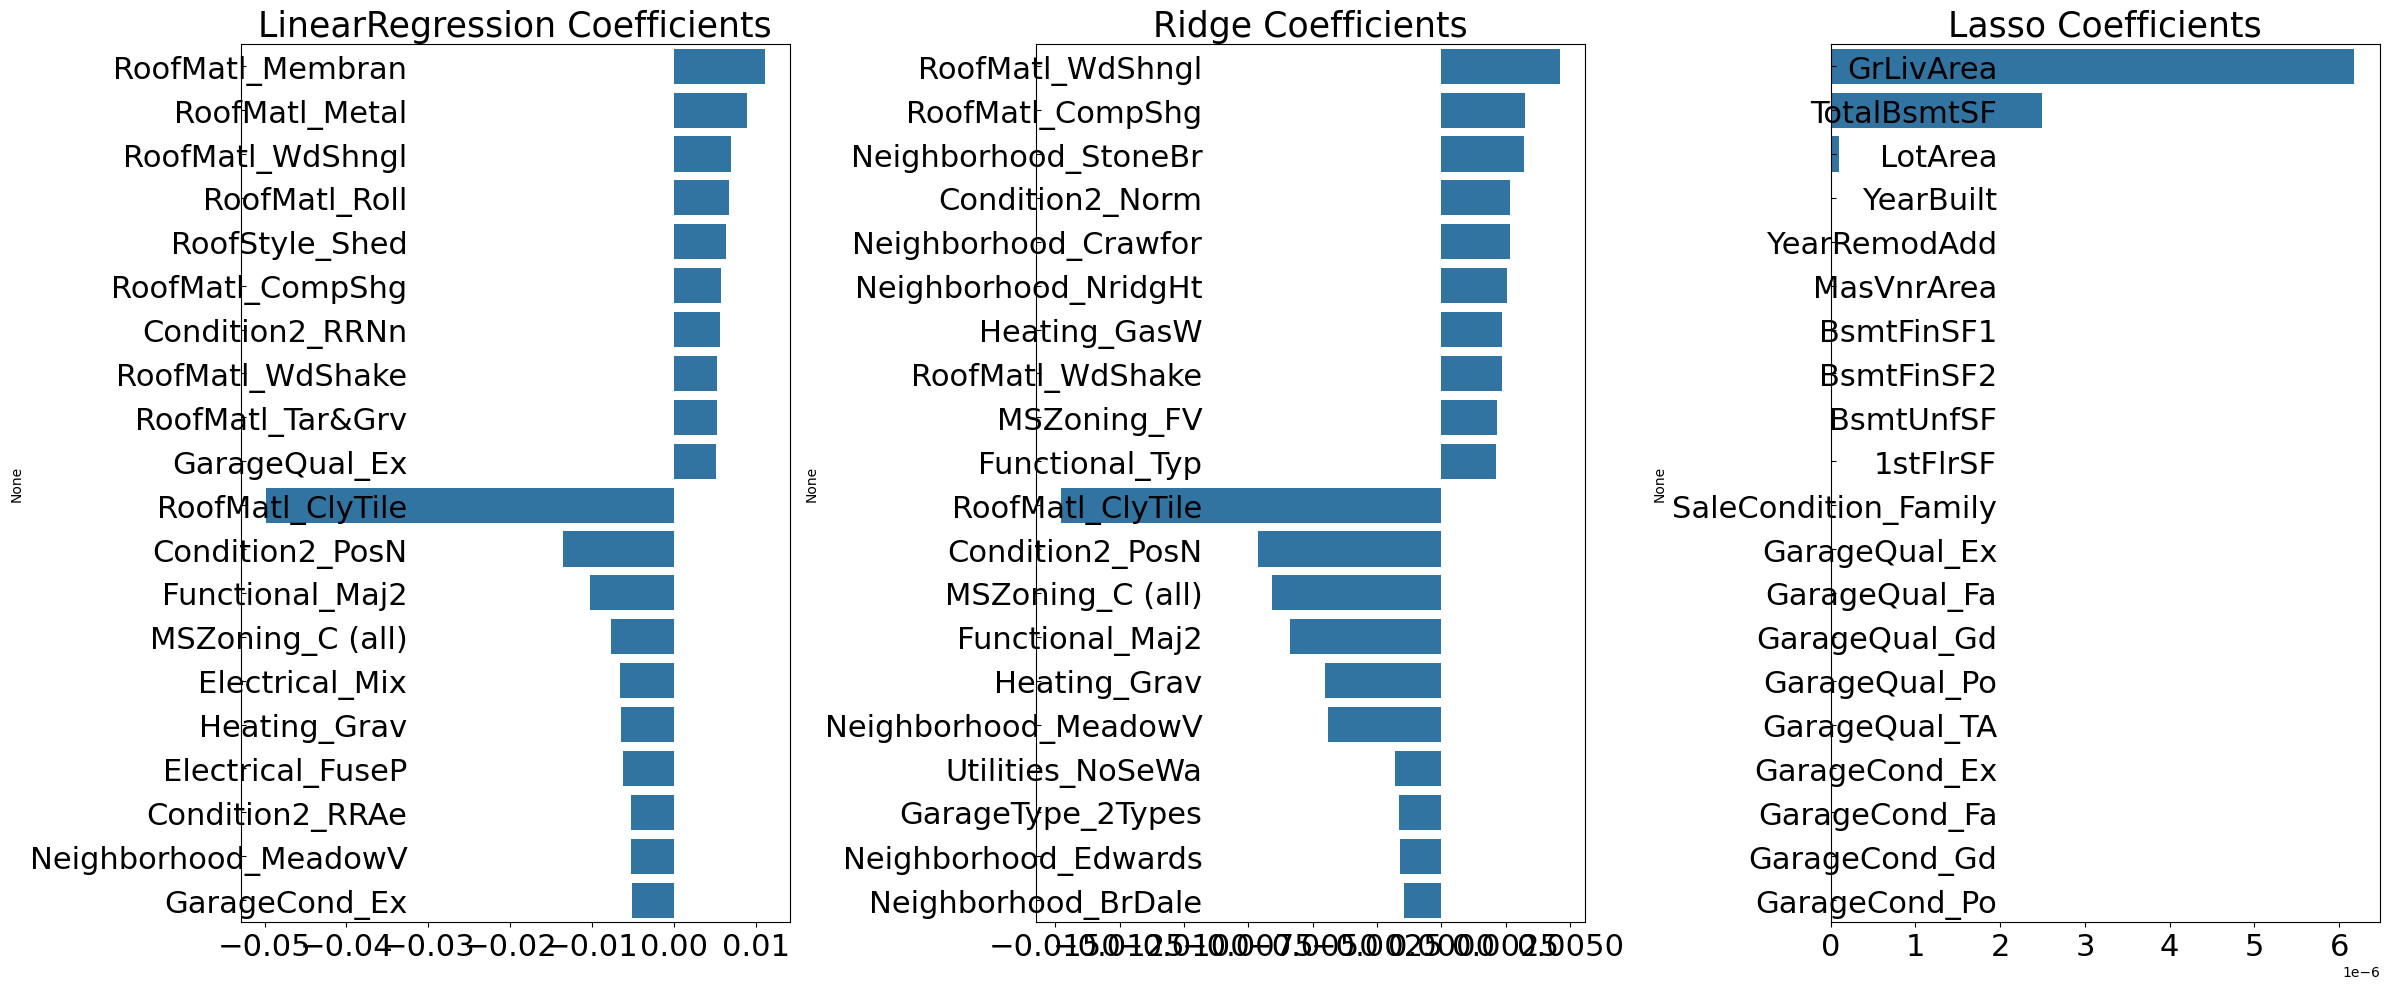

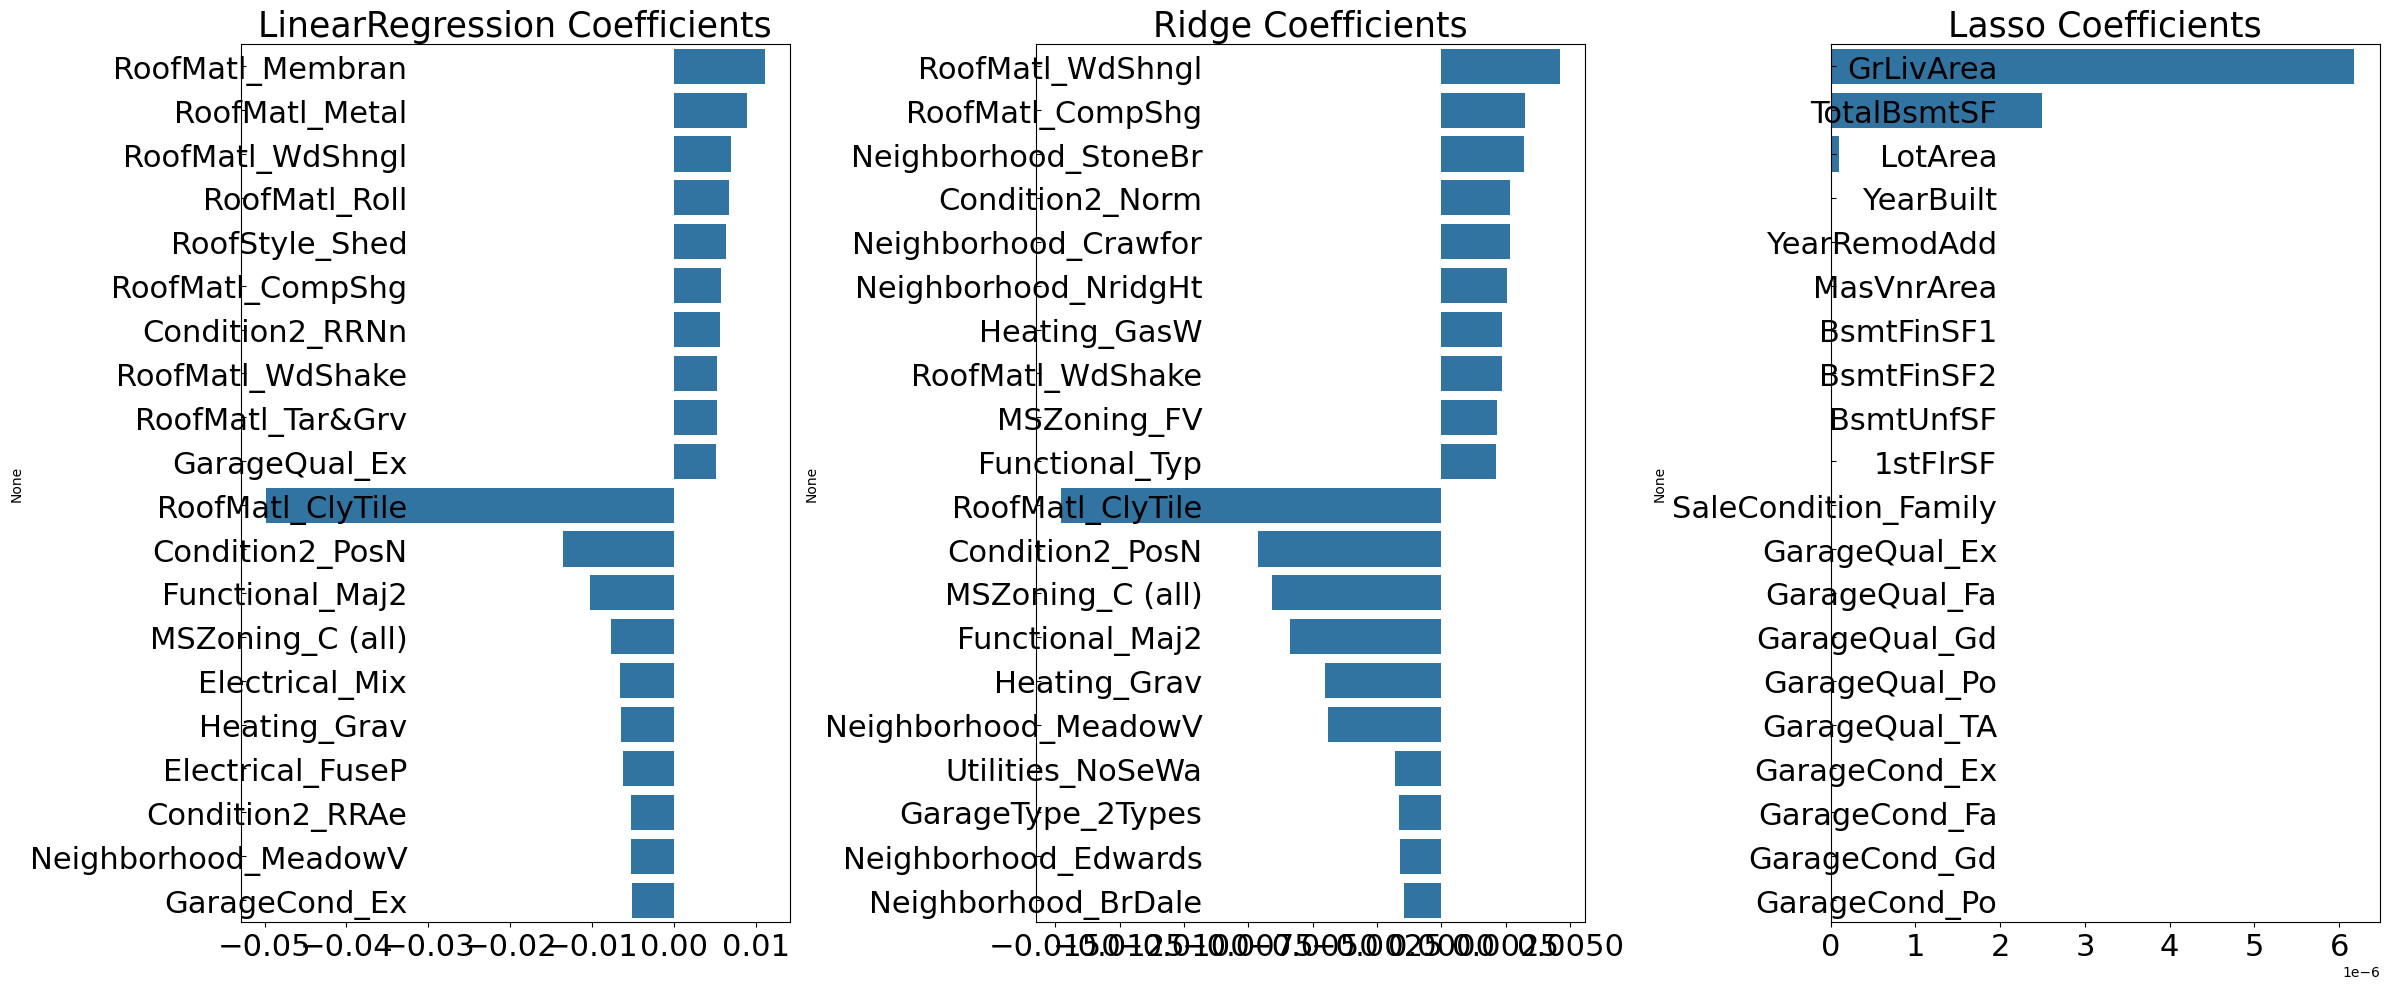

In [18]:
def visualize_coefficient(models):
    fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
    for i_num, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])
        axs[i_num].set_title(model.__class__.__name__ + ' Coefficients', size=25)
        axs[i_num].tick_params(axis='y', direction='in', pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
    fig.tight_layout()

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

plt.show()

In [19]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring='neg_mean_squared_error', cv=5))
        rmse_avg = np.mean(rmse_list)
        print('{0} CV RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))

models = [ridge_reg, lasso_reg]
get_avg_rmse_cv(models)

Ridge CV RMSE 값 리스트: [0.003 0.003 0.003 0.003 0.004]
Ridge CV 평균 RMSE 값: 0.003
Lasso CV RMSE 값 리스트: [0.006 0.007 0.006 0.006 0.006]
Lasso CV 평균 RMSE 값: 0.006


In [21]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))

ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.0031, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값:0.0039, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.003
Ridge 로그 변환된 RMSE: 0.003
Lasso 로그 변환된 RMSE: 0.004


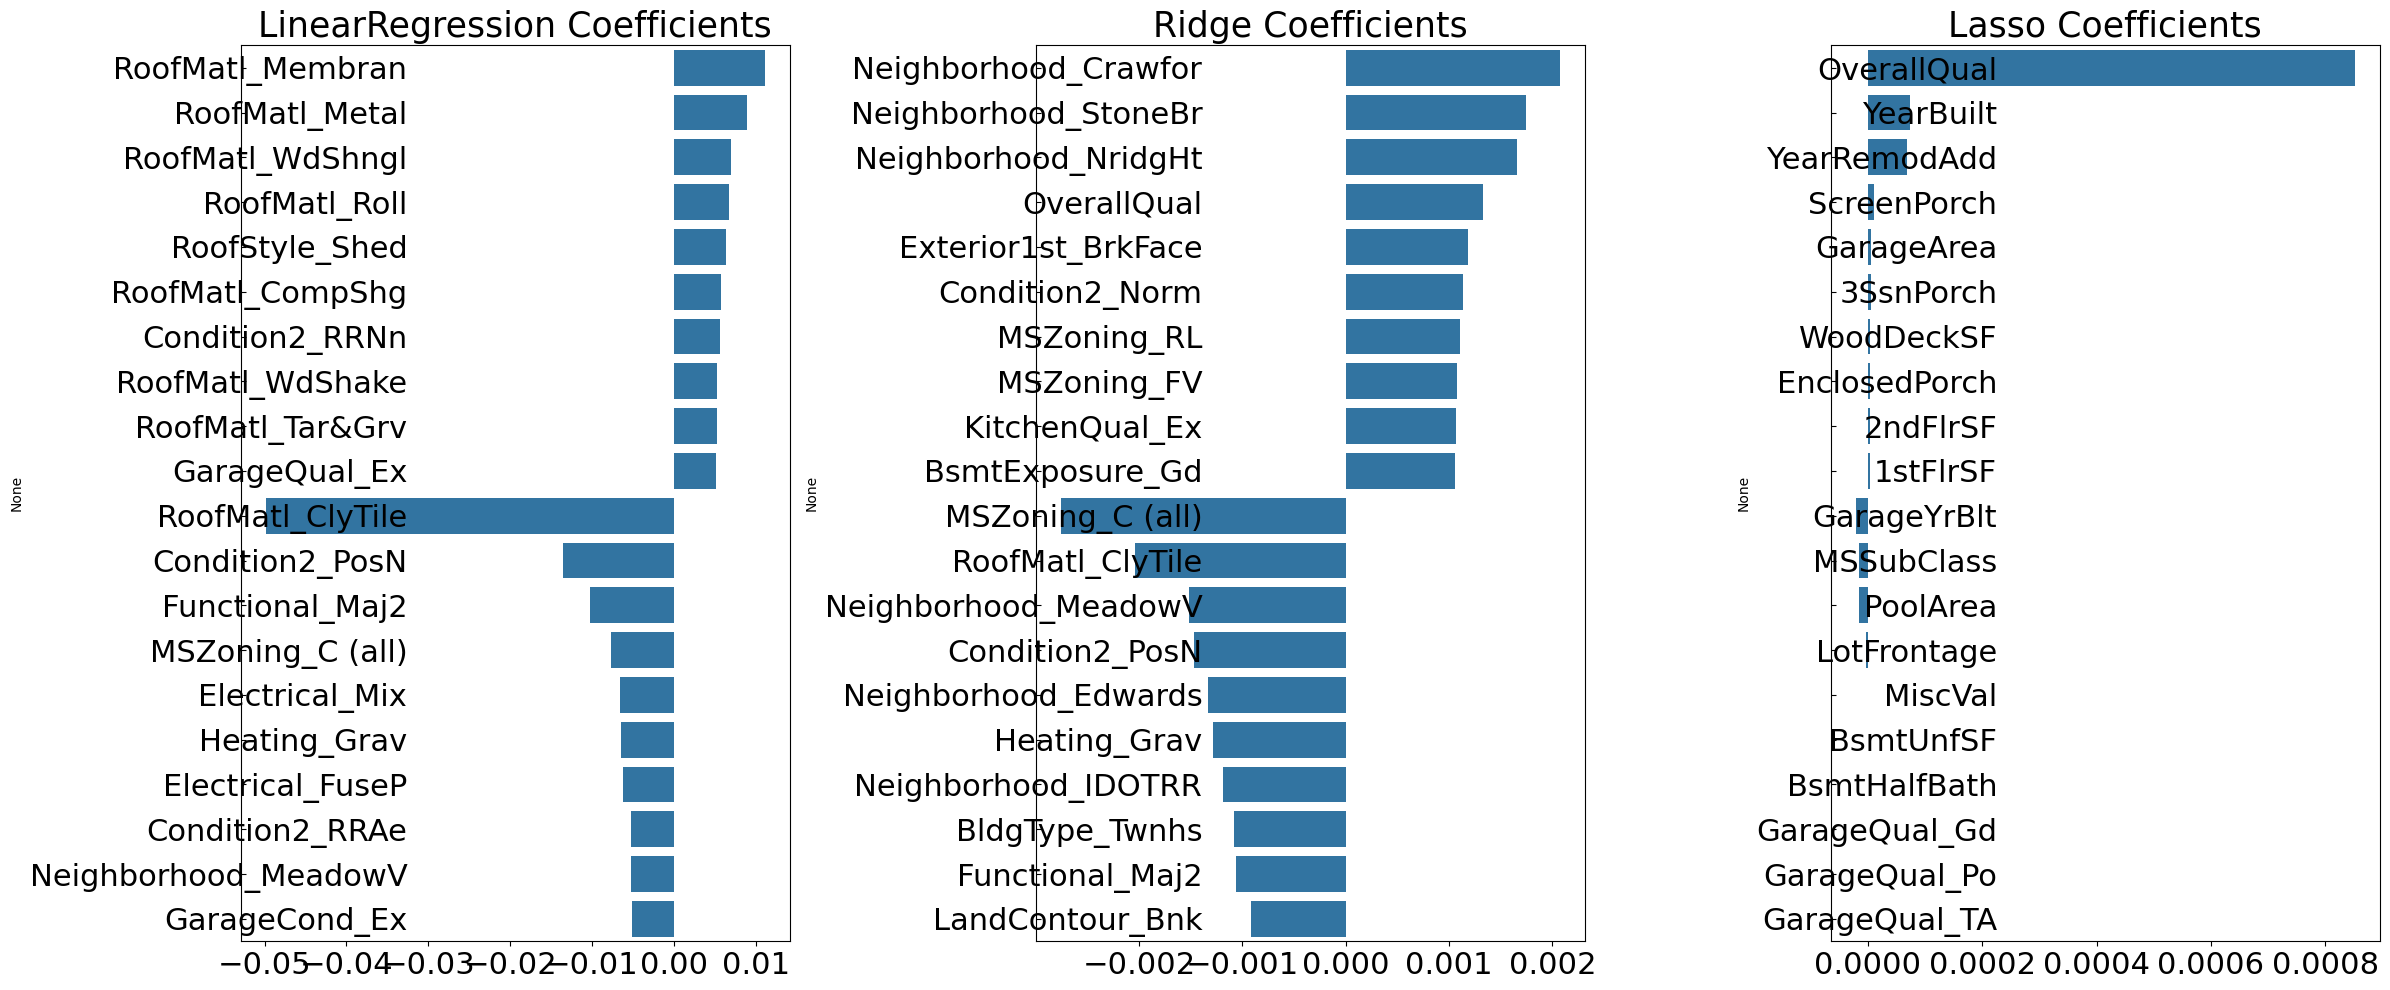

In [22]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

plt.show()

In [23]:
from scipy.stats import skew

features_index = house_df.dtypes[house_df.dtypes != 'object'].index

skew_features = house_df[features_index].apply(lambda x: skew(x))

skew_features_top = skew_features[skew_features > 1]

print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [24]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [27]:
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.0028, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값:0.004, 최적 alpha:{'alpha': 0.001}


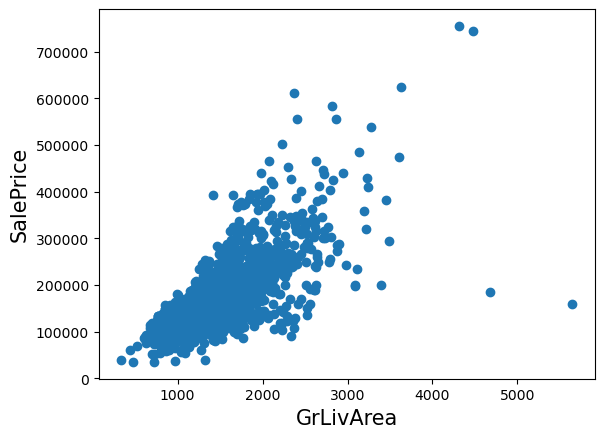

In [29]:
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [30]:
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)

outlier_index = house_df_ohe[cond1 & cond2].index

print('이상치 레코드 index:', outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape:', house_df_ohe.shape)

house_df_ohe.drop(outlier_index, axis=0, inplace=True)

print('이상치 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

이상치 레코드 index: [ 523  691 1182 1298]
이상치 삭제 전 house_df_ohe shape: (1460, 270)
이상치 삭제 후 house_df_ohe shape: (1456, 270)


In [31]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_target, test_size=0.2, random_state=156
)

ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.0025, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값:0.0039, 최적 alpha:{'alpha': 0.001}


In [33]:
from lightgbm.sklearn import LGBMRegressor

lgbm_params = {'n_estimators': [1000]}

lgbm_reg = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=4,
    subsample=0.6,
    colsample_bytree=0.4,
    reg_lambda=10,
    n_jobs=-1
)

print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값:0.0026, 최적 alpha:{'n_estimators': 1000}


In [34]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

pred = 0.4 * ridge_pred + 0.6 * lasso_pred

preds = {
    '최종 혼합': pred,
    'Ridge': ridge_pred,
    'Lasso': lasso_pred
}

get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.003191230322029775
Ridge 모델의 RMSE: 0.002641056822473916
Lasso 모델의 RMSE: 0.003934526835651825


In [35]:
xgb_reg = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    colsample_bytree=0.5,
    subsample=0.8
)

lgbm_reg = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=4,
    subsample=0.6,
    colsample_bytree=0.4,
    reg_lambda=10,
    n_jobs=-1
)

xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)

xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred

preds = {
    '최종 혼합': pred,
    'XGBM': xgb_pred,
    'LGBM': lgbm_pred
}

get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.002668705116688661
XGBM 모델의 RMSE: 0.0027865861303423946
LGBM 모델의 RMSE: 0.0026942000743594417


In [36]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    X_train_n = np.asarray(X_train_n)
    y_train_n = np.asarray(y_train_n)
    X_test_n = np.asarray(X_test_n)

    kf = KFold(n_splits=n_folds, shuffle=False)

    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))

    print(model.__class__.__name__, 'model 시작')
    for fold_idx, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t폴드 세트:', fold_idx, '시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        test_pred[:, fold_idx] = model.predict(X_test_n)

    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)
    return train_fold_pred, test_pred_mean

In [37]:
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge model 시작
	폴드 세트: 0 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작
Lasso model 시작
	폴드 세트: 0 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작
XGBRegressor model 시작
	폴드 세트: 0 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작
LGBMRegressor model 시작
	폴드 세트: 0 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작


In [38]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# 최종 메타 모델 (라쏘)
meta_model_lasso = Lasso(alpha=0.0005)

# 메타 모델 학습 및 예측
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)

mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.00904930074606517
